In [658]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

# Workshop 5
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
sns.set()
sns.set_style("white")
sns.set_palette("GnBu_d")

# also import these "new" libraries 
# Note: you may have to download an add them to your environment (using e.g. 'conda install -c conda-forge folium')

import folium
from folium import plugins
from folium.plugins import HeatMap
from datetime import datetime #for working with times objects
from datetime import timedelta #for working with times objects
import math
import random
#import timeit

In [659]:
data = pd.read_csv("philadelphia_2019.csv")
weatherData = pd.read_csv("weather_hourly_philadelphia.csv")

# 1.1 Quick overview

In [660]:
data.head()

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name
0,2019-01-01 00:19:00,2019-01-01 00:27:00,3049,3007,14495,Indego30,Foglietta Plaza,"11th & Pine, Kahn Park"
1,2019-01-01 00:30:00,2019-01-01 00:37:00,3005,3007,5332,Day Pass,"Welcome Park, NPS","11th & Pine, Kahn Park"
2,2019-01-01 00:52:00,2019-01-01 01:05:00,3166,3169,14623,Indego30,Frankford & Belgrade,2nd & Race
3,2019-01-01 00:55:00,2019-01-01 01:04:00,3058,3103,11706,Indego30,20th & Fairmount,"27th & Master, Athletic Recreation Center"
4,2019-01-01 01:05:00,2019-01-01 01:17:00,3182,3028,11039,Indego30,17th & Sansom,4th & Bainbridge


In [661]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744260 entries, 0 to 744259
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   start_time          744260 non-null  object
 1   end_time            744260 non-null  object
 2   start_station_id    744260 non-null  int64 
 3   end_station_id      744260 non-null  int64 
 4   bike_id             744260 non-null  int64 
 5   user_type           744225 non-null  object
 6   start_station_name  744260 non-null  object
 7   end_station_name    744260 non-null  object
dtypes: int64(3), object(5)
memory usage: 45.4+ MB


In [662]:
# different user types
user_types = data['user_type'].unique()
user_types

array(['Indego30', 'Day Pass', 'Indego365', 'IndegoFlex', 'Walk-up', nan],
      dtype=object)

In [663]:
# number of each user type
data['user_type'].value_counts()      

Indego30      505872
Indego365     147580
Day Pass       89137
IndegoFlex      1410
Walk-up          226
Name: user_type, dtype: int64

In [691]:
weatherData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43848 entries, 0 to 43847
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date_time  43785 non-null  object 
 1   max_temp   43785 non-null  float64
 2   min_temp   43785 non-null  float64
 3   precip     43785 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.3+ MB


In [693]:
weatherData['precip'].describe()

count    43785.000000
mean         0.087770
std          0.282963
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: precip, dtype: float64

# 1.2 Data Preparation

## 1.2.1 Dealing with missing values

In [664]:
data.isnull().sum()

start_time             0
end_time               0
start_station_id       0
end_station_id         0
bike_id                0
user_type             35
start_station_name     0
end_station_name       0
dtype: int64

because there are only 35 out of 744260 rows with missing values, we can simply drop these rows

In [680]:
data_clean = data.dropna(axis=0, inplace=False)
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 744225 entries, 567069 to 498494
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   start_time          744225 non-null  datetime64[ns]
 1   end_time            744225 non-null  datetime64[ns]
 2   start_station_id    744225 non-null  int64         
 3   end_station_id      744225 non-null  int64         
 4   bike_id             744225 non-null  int64         
 5   user_type           744225 non-null  object        
 6   start_station_name  744225 non-null  object        
 7   end_station_name    744225 non-null  object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 51.1+ MB


## 1.2.2 Formatting

In [683]:
data_clean.sort_values(["bike_id","start_time"], inplace=False)
data_clean["start_time"] = pd.to_datetime(data["start_time"])
data_clean["end_time"] = pd.to_datetime(data["end_time"])

In [684]:
#type(data["end_time"])
type(data_clean["start_time"])

pandas.core.series.Series

In [685]:
data_clean.head(30)

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name
567069,2019-09-27 12:48:00,2019-09-27 13:04:00,3167,3078,1,Indego365,12th & Chestnut,19th & Market
567125,2019-09-27 13:05:00,2019-09-27 14:46:00,3078,3000,1,Indego365,19th & Market,Virtual Station
644780,2019-10-26 13:10:23,2019-10-26 14:10:23,3162,3000,42,Day Pass,27th & South,Virtual Station
723290,2019-12-11 14:19:12,2019-12-11 14:52:43,3042,3042,44,Indego365,3042,3042
723350,2019-12-11 15:09:05,2019-12-11 16:25:57,3042,3000,44,Indego365,3042,Virtual Station
737295,2019-12-23 19:01:59,2019-12-24 09:05:14,3161,3158,44,Indego30,30th Street Station East,Broad & Passyunk
709595,2019-11-30 11:35:37,2019-11-30 11:38:50,3010,3000,47,Indego365,15th & Spruce,Virtual Station
714212,2019-12-04 13:05:00,2019-12-04 13:16:53,3042,3042,47,Indego365,3042,3042
9497,2019-01-09 15:05:00,2019-01-09 15:08:00,3115,3075,102,Indego30,"19th & Girard, PTTI",Fairmount & Ridge
10271,2019-01-10 07:43:00,2019-01-10 07:50:00,3075,3037,102,Indego30,Fairmount & Ridge,Pennsylvania Convention Center


In [686]:
# Maps time of day and day of week to our DF

def get_date (ts):
    return ts.date()

def get_weekday (ts):
    return ts.weekday()

def get_hour (ts):
    return ts.hour

def get_minute (ts):
    return ts.minute

In [687]:
# splits start/ end time further into date, weekday, hour and minute

data_clean["Start_date"] = data_clean["start_time"].apply(lambda ts: get_date (ts))
data_clean["Start_weekday"]=data_clean["start_time"].apply(lambda x: get_weekday (x))
data_clean["Start_hour"]=data_clean["start_time"].apply(lambda x: get_hour (x))
data_clean["Start_minute"]=data_clean["start_time"].apply(lambda x: get_minute (x))

data_clean["End_date"] = data_clean["end_time"].apply(lambda ts: get_date (ts))
data_clean["End_weekday"]=data_clean["end_time"].apply(lambda x: get_weekday (x))
data_clean["End_hour"]=data_clean["end_time"].apply(lambda x: get_hour (x))
data_clean["End_minute"]=data_clean["end_time"].apply(lambda x: get_minute (x))

In [688]:
data_clean.head()

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,Start_date,Start_weekday,Start_hour,Start_minute,End_date,End_weekday,End_hour,End_minute
567069,2019-09-27 12:48:00,2019-09-27 13:04:00,3167,3078,1,Indego365,12th & Chestnut,19th & Market,2019-09-27,4,12,48,2019-09-27,4,13,4
567125,2019-09-27 13:05:00,2019-09-27 14:46:00,3078,3000,1,Indego365,19th & Market,Virtual Station,2019-09-27,4,13,5,2019-09-27,4,14,46
644780,2019-10-26 13:10:23,2019-10-26 14:10:23,3162,3000,42,Day Pass,27th & South,Virtual Station,2019-10-26,5,13,10,2019-10-26,5,14,10
723290,2019-12-11 14:19:12,2019-12-11 14:52:43,3042,3042,44,Indego365,3042,3042,2019-12-11,2,14,19,2019-12-11,2,14,52
723350,2019-12-11 15:09:05,2019-12-11 16:25:57,3042,3000,44,Indego365,3042,Virtual Station,2019-12-11,2,15,9,2019-12-11,2,16,25


In [689]:
# adds column with verbosed weekday into DF
weekday_dict = {0:"Mon", 1:"Tue", 2:"Wed", 3:"Thu", 4:"Fri", 5:"Sat", 6:"Sun"}
data_clean["Weekday_verbose_start"] = data_clean["Start_weekday"].apply(lambda x: weekday_dict[x])
data_clean["Weekday_verbose_end"] = data_clean["End_weekday"].apply(lambda x: weekday_dict[x])

In [673]:
data_clean.head()

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,Start_date,Start_weekday,Start_hour,Start_minute,End_date,End_weekday,End_hour,End_minute,Weekday_verbose_start,Weekday_verbose_end
567069,2019-09-27 12:48:00,2019-09-27 13:04:00,3167,3078,1,Indego365,12th & Chestnut,19th & Market,2019-09-27,4,12,48,2019-09-27,4,13,4,Fri,Fri
567125,2019-09-27 13:05:00,2019-09-27 14:46:00,3078,3000,1,Indego365,19th & Market,Virtual Station,2019-09-27,4,13,5,2019-09-27,4,14,46,Fri,Fri
644780,2019-10-26 13:10:23,2019-10-26 14:10:23,3162,3000,42,Day Pass,27th & South,Virtual Station,2019-10-26,5,13,10,2019-10-26,5,14,10,Sat,Sat
723290,2019-12-11 14:19:12,2019-12-11 14:52:43,3042,3042,44,Indego365,3042,3042,2019-12-11,2,14,19,2019-12-11,2,14,52,Wed,Wed
723350,2019-12-11 15:09:05,2019-12-11 16:25:57,3042,3000,44,Indego365,3042,Virtual Station,2019-12-11,2,15,9,2019-12-11,2,16,25,Wed,Wed


# Fleet Size and Availability

In [674]:
fleet_size = len(data_clean["bike_id"].unique())

print("The bike fleet from Indego consists of {} bikes (for the observed time frame)".format(fleet_size))

The bike fleet from Indego consists of 1677 bikes (for the observed time frame)


# 2. Temporal Demand Patterns and Seasonality

## 2.1 Average Usage per Weekday

In [675]:
# Availability by day of week 

bike_trips_weekday = data_clean.groupby(["Start_date", "Weekday_verbose_start"]).size().unstack(fill_value=0)
mean = ['mean']
bike_trips_mean_per_weekday = pd.DataFrame(bike_trips_weekday[["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]].mean(), columns=mean)
bike_trips_mean_per_weekday

,mean
Weekday_verbose_start,
Mon,295.797260
Tue,323.430137
Wed,312.917808
Thu,303.898630
Fri,309.106849
Sat,266.994521
Sun,226.827397


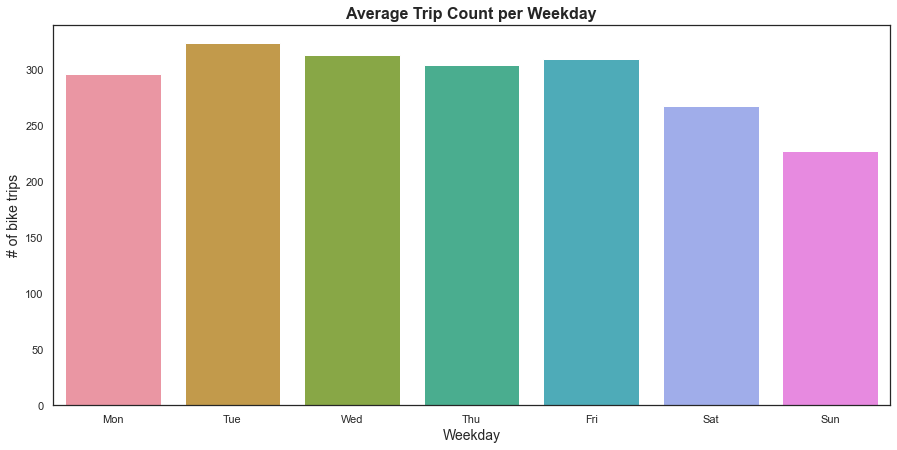

In [690]:
fig,ax = plt.subplots(figsize=(15,7)) 

sns.barplot(x=bike_trips_mean_per_weekday.index, y='mean', data=bike_trips_mean_per_weekday, ax=ax)
ax.set_title('Average Trip Count per Weekday', fontdict={'fontsize': 16, 'fontweight': 'bold'})
ax.set_ylabel("# of bike trips", fontsize=14)
ax.set_xlabel("Weekday", fontsize=14)

plt.show()